### Print result in LaTeX table format

##### Result of `num_train=25000`

In [1]:
from collections import defaultdict
from itertools import product
import yaml

import numpy as np
import wandb

api = wandb.Api()

with open('configs/wandb.yaml', 'r') as file:
    config = yaml.safe_load(file)

account = config['account']
project = config['project']

tables = defaultdict(lambda: {'auc': [], 'accuracy': []})
model_list = [
    'ParticleTransformer', 'ParticleNet', 'ParticleFlowNetwork',
    'ClassicalMPGNN-O64_', 'ClassicalMPGNN-O6_', 'ClassicalMPGNN-O3_',
    'QuantumRotQCGNN-nI4_nQ6', 'QuantumRotQCGNN-nI4_nQ3'
]

for run in api.runs(f"{account}/{project}"):
    if 'C0731' in run.name or 'CQ0715' in run.name:
        for model, dataset in product(model_list, ['JetNet', 'TopQCD']):
            if model in run.name and dataset in run.name:
                key = f"{model}-{dataset}"
                num_train = run.config['Data']['num_train']
                tables[key]['auc'].append(run.summary['test_auc'])
                tables[key]['accuracy'].append(run.summary['test_accuracy'])

In [2]:
for model in model_list:
    print(f"{model}: ")
    for dataset in ['TopQCD', 'JetNet']:
        key = f"{model}-{dataset}"
        auc_mean, auc_std = np.mean(tables[key]['auc']), np.std(tables[key]['auc'])
        accuracy_mean, accuracy_std = np.mean(tables[key]['accuracy']), np.std(tables[key]['accuracy'])
        print(f"{dataset} {auc_mean:.3f}$\\pm${auc_std:.3f} & {accuracy_mean:.3f}$\\pm${accuracy_std:.3f}", end=' | ')
    print('\n')

ParticleTransformer: 
TopQCD 0.946$\pm$0.005 & 0.868$\pm$0.009 | JetNet 0.889$\pm$0.002 & 0.656$\pm$0.006 | 

ParticleNet: 
TopQCD 0.953$\pm$0.003 & 0.885$\pm$0.006 | JetNet 0.896$\pm$0.003 & 0.669$\pm$0.004 | 

ParticleFlowNetwork: 
TopQCD 0.954$\pm$0.004 & 0.885$\pm$0.005 | JetNet 0.900$\pm$0.003 & 0.675$\pm$0.005 | 

ClassicalMPGNN-O64_: 
TopQCD 0.961$\pm$0.003 & 0.896$\pm$0.003 | JetNet 0.903$\pm$0.002 & 0.683$\pm$0.007 | 

ClassicalMPGNN-O6_: 
TopQCD 0.924$\pm$0.006 & 0.866$\pm$0.006 | JetNet 0.865$\pm$0.004 & 0.615$\pm$0.010 | 

ClassicalMPGNN-O3_: 
TopQCD 0.922$\pm$0.005 & 0.864$\pm$0.006 | JetNet 0.757$\pm$0.110 & 0.475$\pm$0.141 | 

QuantumRotQCGNN-nI4_nQ6: 
TopQCD 0.932$\pm$0.004 & 0.868$\pm$0.005 | JetNet 0.822$\pm$0.003 & 0.543$\pm$0.006 | 

QuantumRotQCGNN-nI4_nQ3: 
TopQCD 0.919$\pm$0.006 & 0.864$\pm$0.005 | JetNet 0.796$\pm$0.009 & 0.505$\pm$0.014 | 



##### Appendix (varies with `num_train`)

In [3]:
import yaml

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import pandas as pd
import seaborn as sns
import wandb

sns.set_theme()

font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'  # Replace with the actual path
font_properties = FontProperties(fname=font_path, size=12)

api = wandb.Api()

with open('configs/wandb.yaml', 'r') as file:
    config = yaml.safe_load(file)

In [4]:
account = config['account']
project = config['project']

dataset = 'JetNet' # 'JetNet' or 'TopQCD'
df = pd.DataFrame([])
model_name = {
    'ClassicalMPGNN': 'MPGNN',
    'ParticleFlowNetwork': 'PFN',
    'ParticleNet': 'PNet',
    'ParticleTransformer': 'ParT',
}

for run in api.runs(f"{account}/{project}"):
    num_train = run.config['Data']['num_train']
    if run.config['Settings']['suffix'] == 'APP0730' and num_train == 100000:
        x_tick = 'Full-100K'
    elif run.config['Settings']['suffix'] == 'APP0801':
        x_tick = f"{num_train//1000}K"
    else:
        continue
        
    _df = pd.DataFrame({
        'dataset': run.config['dataset'],
        'model': model_name[run.config['model']],
        'x_tick': x_tick,
        'auc': run.summary['test_auc'],
        'accuracy': run.summary['test_accuracy'],
        'rnd_seed': run.config['random_seed'],
    }, index=[0])

    df = pd.concat([df, _df], ignore_index=True)

df

,dataset,model,x_tick,auc,accuracy,rnd_seed
0,JetNet,MPGNN,5K,0.897154,0.67360,0
1,JetNet,PFN,5K,0.895043,0.66800,0
2,JetNet,ParT,5K,0.873368,0.61480,0
3,JetNet,PNet,5K,0.888035,0.65400,0
4,TopQCD,MPGNN,5K,0.934980,0.85900,0
...,...,...,...,...,...,...
235,TopQCD,PNet,Full-100K,0.974645,0.91940,4
236,JetNet,MPGNN,Full-100K,0.932878,0.75166,4
237,JetNet,PFN,Full-100K,0.934281,0.75450,4
238,JetNet,ParT,Full-100K,0.940373,0.76566,4


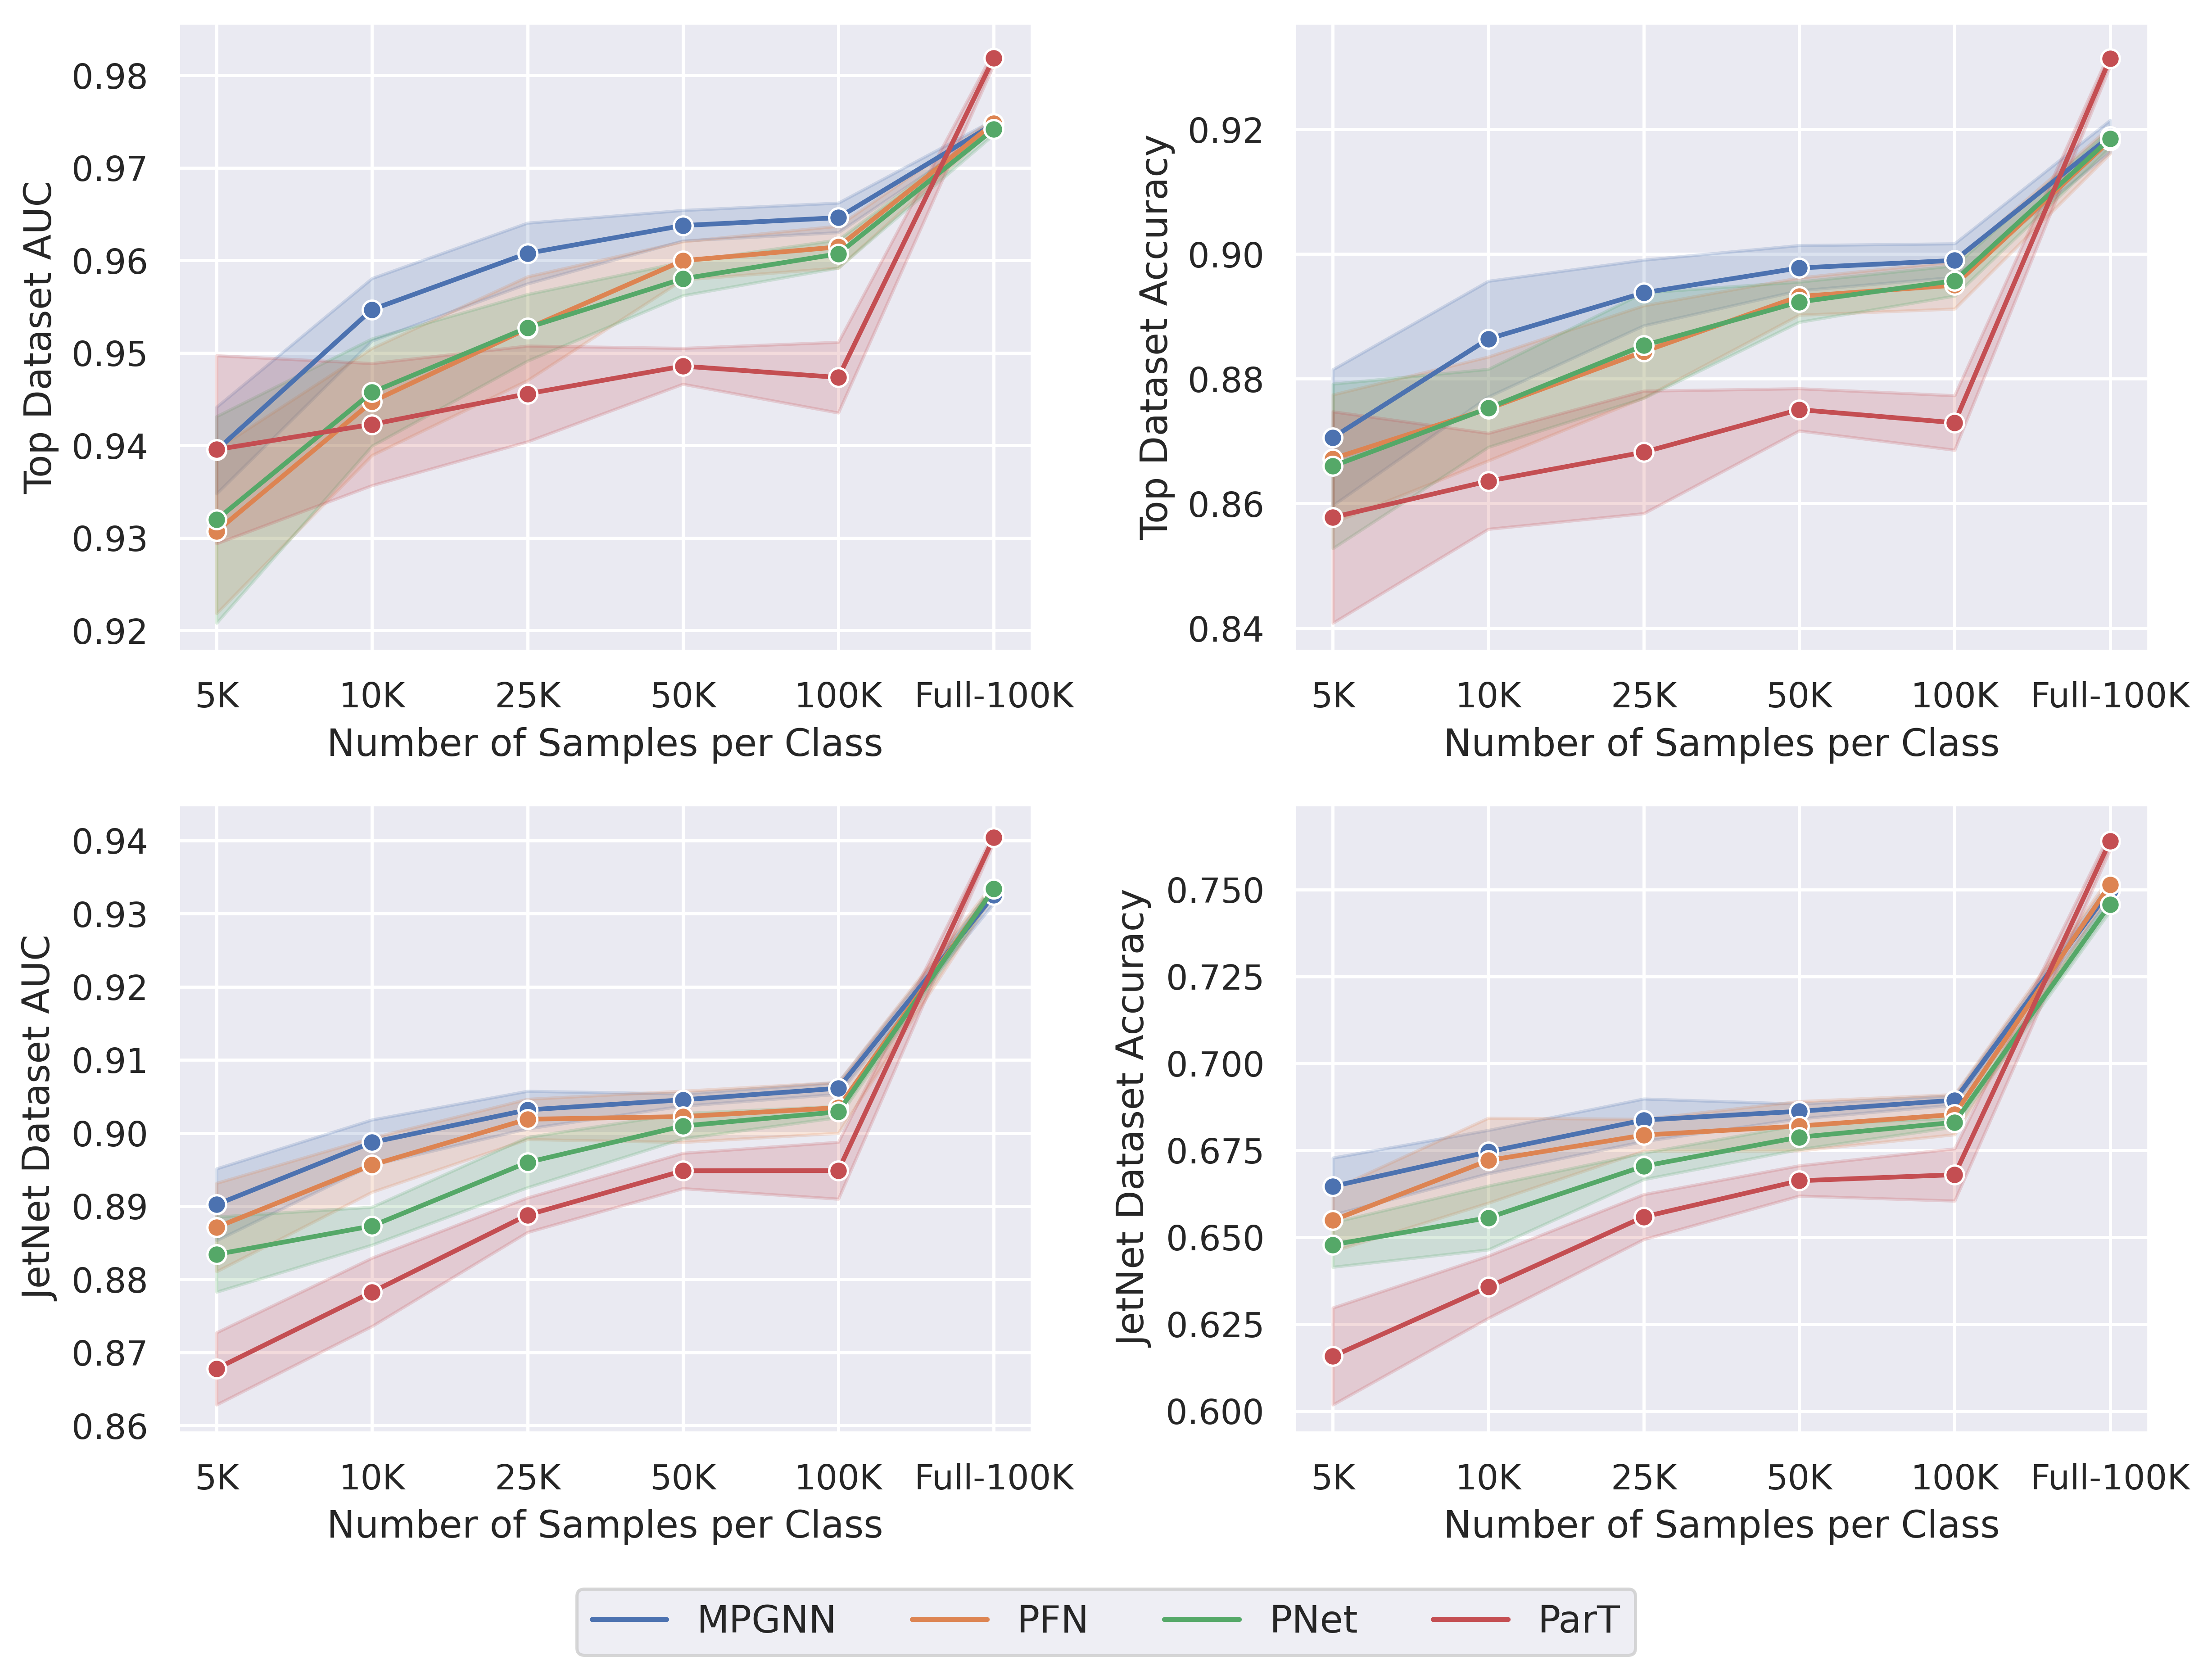

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(10, 7.5), dpi=500)
palette = sns.color_palette()
model_colors = dict(zip(model_name.values(), palette))

def plot_app_num_train(ax: plt.Axes, dataset: str, metric: str, y_label: str):
    for model in model_name.values():
        data = df[(df['dataset'] == dataset) & (df['model'] == model)]
        sns.lineplot(
            data=data, x='x_tick', y=metric, color=model_colors[model],
            ax=ax, marker='o', errorbar=('sd', 1),
        )

    ax.set_xlabel('Number of Samples per Class')
    ax.set_ylabel(y_label)

plot_app_num_train(ax[0][0], dataset='TopQCD', metric='auc', y_label='Top Dataset AUC')
plot_app_num_train(ax[0][1], dataset='TopQCD', metric='accuracy', y_label='Top Dataset Accuracy')
plot_app_num_train(ax[1][0], dataset='JetNet', metric='auc', y_label='JetNet Dataset AUC')
plot_app_num_train(ax[1][1], dataset='JetNet', metric='accuracy', y_label='JetNet Dataset Accuracy')

import matplotlib.lines as mlines
handles = [mlines.Line2D([], [], color=model_colors[model], label=model) for model in model_name.values()]
fig.legend(handles=handles, loc='lower center', ncol=len(model_name), fontsize=12)

plt.tight_layout(rect=[0, 0.05, 1, 1])